<a href="https://colab.research.google.com/github/alheir/22-67-neural-networks/blob/main/tp_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os, re, csv, math, codecs, logging
from collections import Counter
from pathlib import Path
from io import StringIO
import pickle

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, accuracy_score, confusion_matrix

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

import seaborn as sns
import pickle

## Carga de datos

In [5]:
# stopwords de NLTK
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    words_filtered = [word for word in words if word.lower() not in stop_words]
    return ' '.join(words_filtered)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
newsgroups_train_exists = os.path.exists('/kaggle/input/newsgroups/newsgroups_train.txt')
newsgroups_test_exists = os.path.exists('/kaggle/input/newsgroups/newsgroups_test.txt')



if newsgroups_train_exists:
    with open('/kaggle/input/newsgroups/newsgroups_train.txt', 'rb') as fp:
        newsgroups_train = pickle.load(fp)
else:
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    newsgroups_train.data = [remove_stopwords(text) for text in newsgroups_train.data]

if newsgroups_test_exists:
    with open('/kaggle/input/newsgroups/newsgroups_test.txt', 'rb') as fp:
        newsgroups_test = pickle.load(fp)
else:
    newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
    newsgroups_test.data = [remove_stopwords(text) for text in newsgroups_test.data]

In [9]:
class_num = 20

*Dataset ya analizado en TP1...*

## Descarga y carga de embeddings de Fasttext

In [13]:
wiki_news_exists = os.path.exists('/kaggle/working/wiki-news-300d-1M.vec')
embeddings_index_exists = os.path.exists('/kaggle/working/embeddings_index.pkl')

embeddings_index = {}

if not embeddings_index_exists:
    if not wiki_news_exists:
        !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
        !unzip wiki-news-300d-1M.vec.zip
        os.remove('/kaggle/working/wiki-news-300d-1M.vec.zip')

    # Carga de embeddings de palabras
    with codecs.open('/kaggle/working/wiki-news-300d-1M.vec', encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    with open('/kaggle/working/embeddings_index.pkl', 'wb') as fp:
        pickle.dump(embeddings_index, fp)
else:
    with open('/kaggle/working/embeddings_index.pkl', 'rb') as fp:
        embeddings_index = pickle.load(fp)

print(f'Found {len(embeddings_index)} word vectors')

Found 999995 word vectors


## Tokenización y preparación de secuencias

In [14]:
# vocabulario de 30000
token = Tokenizer(num_words=30000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK")
token.fit_on_texts(newsgroups_train.data)

# idx2word y word2idx
reverse_dictionary = token.index_word
dictionary = token.word_index

# embeddings de las palabras presentes en el vocabulario
embed_dim = 300
num_words = min(30000, len(dictionary) + 1)
embedding_matrix = np.zeros((num_words, embed_dim))
for word, idx in dictionary.items():
    if idx < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

# tokenización de textos
train_sequences = token.texts_to_sequences(newsgroups_train.data)
test_sequences = token.texts_to_sequences(newsgroups_test.data)

# tamaño de contexto a procesar
max_len = 500
train_sequences = pad_sequences(train_sequences, maxlen=max_len)
test_sequences = pad_sequences(test_sequences, maxlen=max_len)

print(f"Train sequences shape: {train_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")

Train sequences shape: (11314, 500)
Test sequences shape: (7532, 500)


## Definición y compilación del modelo

In [22]:
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [71]:
early_stopping = EarlyStopping(monitor="val_loss",
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

model_checkpoint = ModelCheckpoint(filepath='best_model.keras',
                                   monitor = "val_loss",
                                   verbose = 1,
                                   mode='min',
                                   save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor = "val_accuracy",
                              factor = 0.5,
                              patience = 5,
                              verbose = 1,
                              min_lr = 1e-5,
                              min_delta=0.001)

In [61]:
batch_size = 128

In [76]:
model = Sequential()

# 1°: embedding entrenable
model.add(Embedding(input_dim=num_words,
                    output_dim=embed_dim,
                    weights=[embedding_matrix],
                    input_shape=(None,),
                    trainable=True))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dense(128,activation='swish'))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.4))

model.add(LSTM(32))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))


# model.add(Bidirectional(LSTM(32, return_sequences=True)))
# model.add(Dropout(0.5))

# model.add(Bidirectional(LSTM(16)))
# model.add(BatchNormalization())

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())

# model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())

# clasificación con softmax
model.add(Dense(class_num, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(1e-4), metrics=['accuracy'])

model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, None, 300)      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_53                │ (None, None, 256)      │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, None, 128)      │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_54                │ (None, None, 128)      │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,593,396 (36.60 MB)

 Trainable params: 9,593,396 (36.60 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del modelo

In [77]:
history = model.fit(train_sequences,
                    newsgroups_train.target,
                    batch_size=batch_size,
                    epochs=50,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.0575 - loss: 2.9940 - val_accuracy: 0.0884 - val_loss: 2.9861
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.0871 - loss: 2.9645 - val_accuracy: 0.1295 - val_loss: 2.8505
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.1011 - loss: 2.8519 - val_accuracy: 0.1388 - val_loss: 2.7656
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.1090 - loss: 2.7980 - val_accuracy: 0.1662 - val_loss: 2.6972
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 0.1285 - loss: 2.7214 - val_accuracy: 0.1913 - val_loss: 2.6236
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.1562 - loss: 2.6377 - val_accuracy: 0.2139 - val_loss: 2.5239
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.1866 - loss: 2.5288 - val_accuracy: 0.2307 - val_loss: 2.4357
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.2247 - loss: 2.4219 - val_accu

## Evaluación del modelo y visualización de resultados

### Resultados TP1

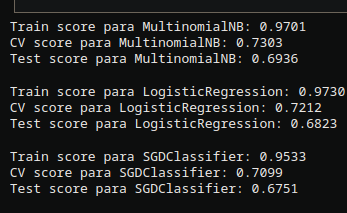

In [78]:
# con datos de prueba
test_loss, test_accuracy = model.evaluate(test_sequences, newsgroups_test.target)
print(f'Test accuracy: {test_accuracy}')

236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.3884 - loss: 2.0259
Test accuracy: 0.3872809410095215


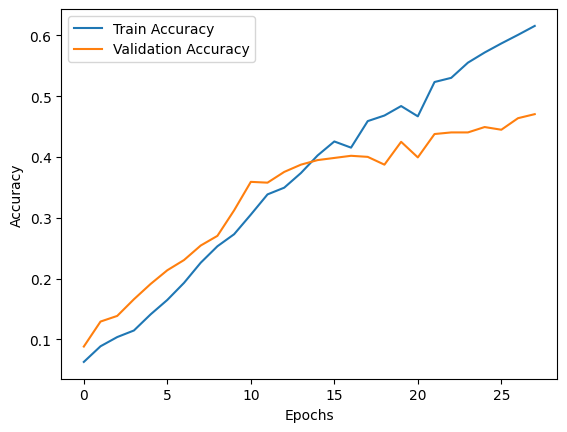

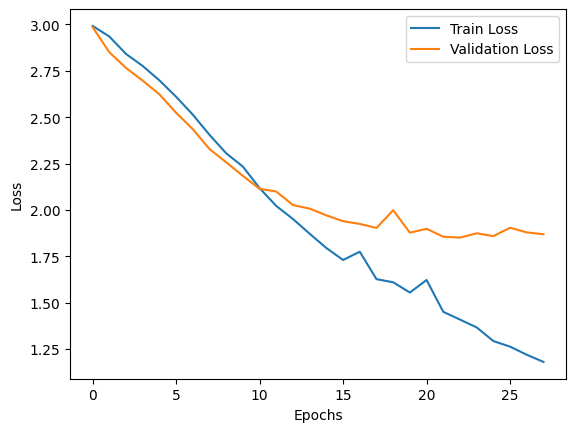

In [79]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
test_predictions = model.predict(test_sequences)
test_predictions = np.argmax(test_predictions, axis=1)

236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step


In [81]:
# métricas
f1 = f1_score(newsgroups_test.target, test_predictions, average='micro')
precision = precision_score(newsgroups_test.target, test_predictions, average='micro')
accuracy = accuracy_score(newsgroups_test.target, test_predictions)
recall = recall_score(newsgroups_test.target, test_predictions, average='micro')
conf_matrix = confusion_matrix(newsgroups_test.target, test_predictions)
class_report = classification_report(newsgroups_test.target, test_predictions, target_names=newsgroups_test.target_names)

print(f'F1-score: {f1}')
print(f'Precision: {precision}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Classification Report:\n{class_report}')

F1-score: 0.38728093467870417
Precision: 0.38728093467870417
Accuracy: 0.38728093467870417
Recall: 0.38728093467870417
Classification Report:
                          precision    recall  f1-score   support

             alt.atheism       0.22      0.29      0.25       319
           comp.graphics       0.30      0.42      0.35       389
 comp.os.ms-windows.misc       0.38      0.29      0.33       394
comp.sys.ibm.pc.hardware       0.42      0.47      0.44       392
   comp.sys.mac.hardware       0.31      0.23      0.27       385
          comp.windows.x       0.60      0.46      0.52       395
            misc.forsale       0.29      0.29      0.29       390
               rec.autos       0.37      0.29      0.33       396
         rec.motorcycles       0.30      0.61      0.40       398
      rec.sport.baseball       0.54      0.46      0.50       397
        rec.sport.hockey       0.75      0.72      0.73       399
               sci.crypt       0.72      0.48      0.58       396

*A confusion matrix represents the prediction summary in matrix form. It shows how many prediction are correct and incorrect per class. It helps in understanding the classes that are being confused by model as other class*

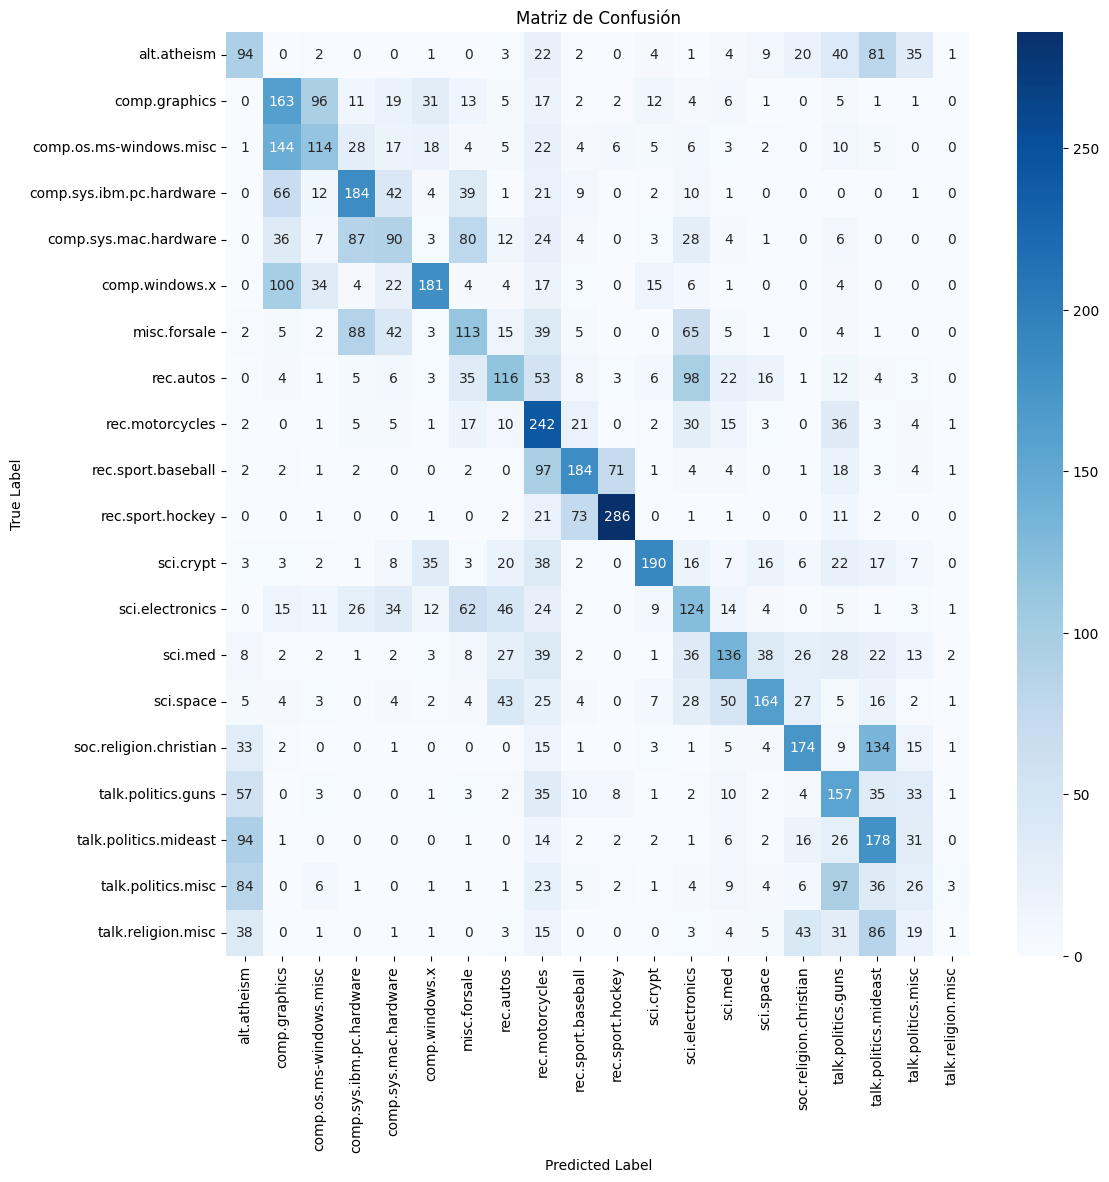

In [83]:
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=newsgroups_test.target_names, yticklabels=newsgroups_test.target_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Para aventurarse


In [ ]:
'''
Tokenizacion: opciones
Elman, LSTM, GRU
Bidireccional
Tamaño de capas y cantidad
Dropout
RMSProp, ADAM
BATCH_SIZE
Unloop
TPU?
Embedding entrenable
Forma de colapsar las secuencias
Reduccion de dimensionalidad embedding
'''